In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
import nltk
import pymorphy2
from nltk.stem import *
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from func.auto import autoTable
import func.cls as cls
from sklearn.decomposition import PCA

# Бинарная классификация

### Предобработка данных

In [2]:
# В прошлый раз 2:12 минуты длилось выполнение ячейки
data2 = cls.read_data_xlsx("data_2cls.xlsx")     # пропущенные значения удалены
title2 = cls.lemmatize_rus(list(data2["name"]))     # Названия
keywords2 = cls.lemmatize_rus(list(data2["keywords"]))   # ключевые слова
annotation2 = cls.lemmatize_rus(list(data2["annotation"]))   # аннотации
united_signs2 = [title2[i] + " " + keywords2[i] + " " + annotation2[i] for i in range(len(title2))]  # Объединенные признаковые пространства
labels2 = [eval(data2['classification_labels'][i])[0]['flag'] for i in range(len(data2['classification_labels']))]
stop_words = stopwords.words('english') + stopwords.words('russian')

## Визуализация

In [31]:
num_labels2 = [None]*len(labels2)
list_labels = list(set(labels2))     # порядок не совпадает
list_labels.sort()
for i in range(len(list_labels)):
    num = np.where(np.array(labels2) == list_labels[i])
    for j in num[0]:
        num_labels2[j] = i

In [112]:
tf_idf2 = TfidfVectorizer(max_features=None, stop_words=stop_words).fit_transform(united_signs2).toarray()

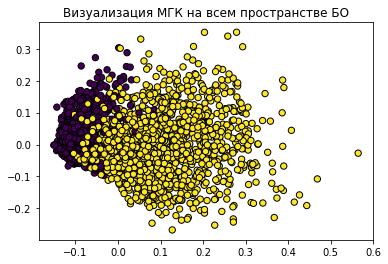

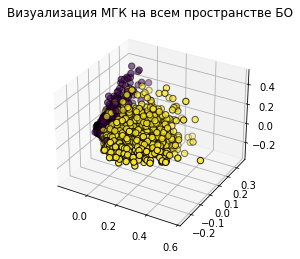

In [114]:
united_signs2_pca = cls.pca(tf_idf2, labels2, title='Визуализация МГК на всем пространстве БО')

## Классификация

In [5]:
title2_tf_idf = TfidfVectorizer(max_features=None, stop_words=stop_words).fit_transform(title2).toarray()
keywords2_tf_idf = TfidfVectorizer(max_features=None, stop_words=stop_words).fit_transform(keywords2).toarray()
annotation2_tf_idf = TfidfVectorizer(max_features=None, stop_words=stop_words).fit_transform(annotation2).toarray()
united_signs2_tf_idf = TfidfVectorizer(max_features=None, stop_words=stop_words).fit_transform(united_signs2).toarray()

In [8]:
print(title2_tf_idf.shape)
print(keywords2_tf_idf.shape)
print(annotation2_tf_idf.shape)
print(united_signs2_tf_idf.shape)

(3266, 6393)
(3266, 12185)
(3266, 19925)
(3266, 25123)


In [19]:
x_train, x_test, y_train, y_test = train_test_split(united_signs2_tf_idf, labels2, train_size=0.3, random_state=0)

### Первый этап

In [20]:
parameters = {
    'n_estimators': (50, 100, 300, 400, 500, 1000),
    'max_depth': (10, 100, 200, 500, None),
    'criterion': ('gini', 'log_loss', 'entropy'),
    'max_features': (0.3, 0.5, 100, "sqrt", "log2", None),
    'max_leaf_nodes': (100, 1000, 25000, None),
    'min_samples_split': (2, 5, 10),
    'min_samples_leaf':  (1, 2, 5, 10),
    'oob_score': (True, False),
    'bootstrap': (True, False),
}

In [21]:
param = {}
for key in list(parameters.keys()):
    print(key)
    param.update({key: parameters[key]})
    clf = RandomForestClassifier(random_state=0)
    prediction, classificationReport, best_params = cls.classifier(x_train, x_test, y_train, y_test, clf, param)
    param = best_params
    for key in list(param.keys()):
        param.update({key: (param[key],)})

n_estimators
max_depth
criterion


c:\Users\Igorexy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 9.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Igorexy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Igorexy\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "c:\Users\Igorexy\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\Igorexy\anaconda3\lib\site-pack

max_features
max_leaf_nodes
min_samples_split
min_samples_leaf
oob_score
bootstrap


c:\Users\Igorexy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 6.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Igorexy\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Igorexy\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 411, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueError: Out of bag estimation only available if bootstrap=True

  warnings.warn(some_fits_failed_message, FitFailedWarning)
c:

In [22]:
print(classificationReport)
best_params

              precision    recall  f1-score   support

       False       0.99      1.00      0.99      1228
        True       1.00      0.98      0.99      1059

    accuracy                           0.99      2287
   macro avg       0.99      0.99      0.99      2287
weighted avg       0.99      0.99      0.99      2287



{'bootstrap': (True,),
 'criterion': ('entropy',),
 'max_depth': (100,),
 'max_features': (0.3,),
 'max_leaf_nodes': (None,),
 'min_samples_leaf': (1,),
 'min_samples_split': (2,),
 'n_estimators': (500,),
 'oob_score': (True,)}

### Этап донастройки

In [27]:
param = {'bootstrap': (True,),
        'criterion': ('entropy',),
        'max_depth': (100,),
        'max_features': (0.1,),
        'max_leaf_nodes': (None,),
        'min_samples_leaf': (1,),
        'min_samples_split': (2,),
        'n_estimators': (500, 600, 700, 800),
        'oob_score': (True,)}
clf = RandomForestClassifier(random_state=0)

prediction, classificationReport, best_params = cls.classifier(x_train, x_test, y_train, y_test, clf, param)
print(classificationReport)
best_params

              precision    recall  f1-score   support

       False       0.99      0.99      0.99      1228
        True       0.99      0.99      0.99      1059

    accuracy                           0.99      2287
   macro avg       0.99      0.99      0.99      2287
weighted avg       0.99      0.99      0.99      2287



{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 100,
 'max_features': 0.1,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 700,
 'oob_score': True}

In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, prediction)

array([[1220,    8],
       [   9, 1050]], dtype=int64)

### Save

In [29]:
autoTable(classificationReport, path='output/united_signs2 RF.docx')

### Сравненительный график

In [4]:
table_bin = pd.read_excel('Таблица метрик бинарной классификации.xlsx', index_col=0)

In [5]:
table_bin

,Accuracy name,Macro avg F1 name,Accuracy bibliographic description,Macro avg F1 bibliographic description,Accuracy keywords
Логистическая регрессия,0.87,0.87,0.96,0.96,0.96
КБС,0.77,0.77,0.85,0.85,0.84
Дерево решений,0.80,0.80,0.99,0.99,0.96
Случайный лес,0.87,0.87,0.99,0.99,0.97


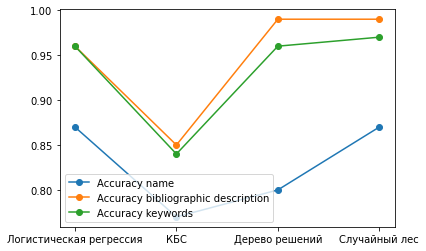

In [6]:
plt.figure()
plt.plot(list(table_bin.index), list(table_bin['Accuracy name']), marker='o', label='Accuracy name')
plt.plot(list(table_bin.index), list(table_bin['Accuracy bibliographic description']), marker='o', label='Accuracy bibliographic description')
plt.plot(list(table_bin.index), list(table_bin['Accuracy keywords']), marker='o', label='Accuracy keywords')
plt.legend()

# Многоклассовая классификация

In [9]:
data10 = cls.read_data_xlsx("data_10cls.xlsx")
print(data10.columns)
title10 = cls.lemmatize(list(data10["title"]))     # Названия
keywords10 = cls.lemmatize(list(data10["tags_names"]))   # ключевые слова
annotation10 = cls.lemmatize(list(data10["abstract"]))   # аннотации

# Убираем пропуски значений в tags_names, были nan, в других признаквых пространствах пропусков не обнаружено
tags_names10 = list(np.where(np.array(keywords10) == ' nan', '', keywords10))
united_signs10 = [title10[i] + " " + keywords10[i] + " " + annotation10[i] for i in range(len(title10))]  # Объединенные признаковые пространства
labels10 = list(data10["marker"])

Index(['url', 'title', 'tags_codes', 'tags_names', 'authors', 'abstract',
       'submitted', 'marker'],
      dtype='object')


### Визуализация

In [46]:
num_labels10 = ['']*len(labels10)
set_lb = list(set(labels10))
for lb in set_lb:
    indexes = np.where(np.array(labels10)==lb)[0]
    k = set_lb.index(lb)
    for i in indexes:
        num_labels10[i] = k

In [4]:
tf_idf10 = TfidfVectorizer(max_features=None, stop_words='english').fit_transform(united_signs10).toarray()

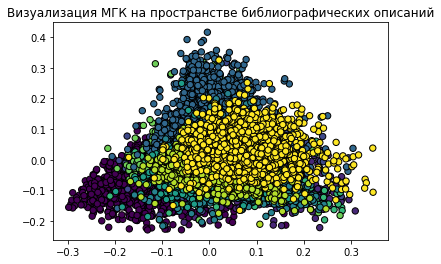

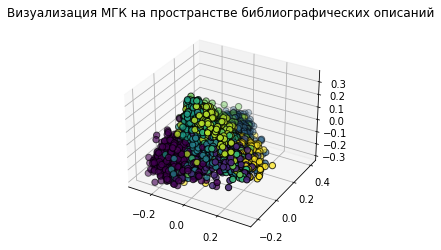

In [49]:
_pcaRes = cls.pca(tf_idf10, num_labels10, title='Визуализация МГК на пространстве библиографических описаний')

In [100]:
_pcaRes[0]

array([[-0.08101594,  0.00854087],
       [-0.14803393, -0.00711777],
       [-0.14698643, -0.04262413],
       ...,
       [ 0.04459024,  0.00528488],
       [ 0.05026557,  0.08090325],
       [ 0.02872109,  0.0874203 ]])

In [104]:
_pcaRes[0][[1, -1],0]

array([-0.14803393,  0.02872109])

In [125]:
colors = ['r', 'g', 'c', 'y', 'k', 'purple', 'gray', 'olive', 'navy', 'teal']
len(colors)

10

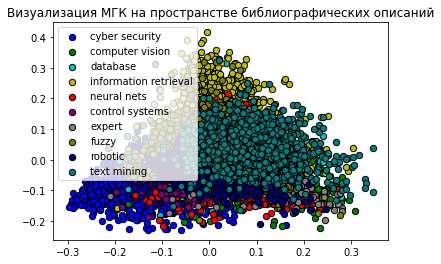

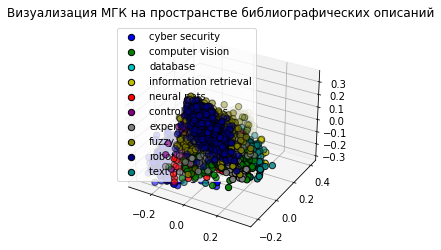

In [158]:
colors = ['b', 'g', 'c', 'y', 'r', 'purple', 'gray', 'olive', 'navy', 'teal']
legend_elements = []
for i in list(set(num_labels10)):
    indexes = np.where(np.array(num_labels10)==i)[0]

    s = plt.scatter(_pcaRes[0][indexes,0], _pcaRes[0][indexes,1], c=colors[i], edgecolor="k", s=40)

# plt.title(title) 
# Список легенды
    legend_elements.append(s)

# Добавление легенды
plt.legend(handles=legend_elements, labels=set(labels10), loc='upper left')
plt.title('Визуализация МГК на пространстве библиографических описаний') 
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

colors = ['b', 'g', 'c', 'y', 'r', 'purple', 'gray', 'olive', 'navy', 'teal']
legend_elements = []
for i in list(set(num_labels10)):
    indexes = np.where(np.array(num_labels10)==i)[0]

    s = ax.scatter(_pcaRes[1][indexes,0], _pcaRes[1][indexes,1], _pcaRes[1][indexes,2], c=colors[i], edgecolor="k", s=40)
    legend_elements.append(s)
plt.title('Визуализация МГК на пространстве библиографических описаний') 
# Список легенды

# Добавление легенды
plt.legend(handles=legend_elements, labels=set(labels10), loc='upper left')

# plt.legend(handles=num_labels10, labels=labels10)
plt.show()

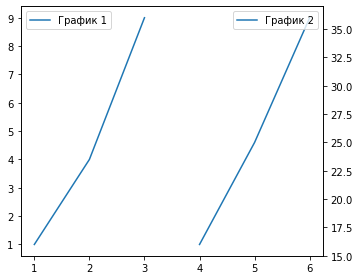

In [143]:
import matplotlib.pyplot as plt

# Создание графика и подграфиков
fig, ax = plt.subplots()
ax2 = ax.twinx()  # Создание дополнительного подграфика

# Построение данных на графике и подграфиках
ax.plot(x1, y1, label='График 1')
ax2.plot(x2, y2, label='График 2')

# Расширение графика и размещение легенды сбоку
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
fig.tight_layout(rect=[0, 0, 0.85, 1])  # Установка размеров графика

# Отображение графика
plt.show()


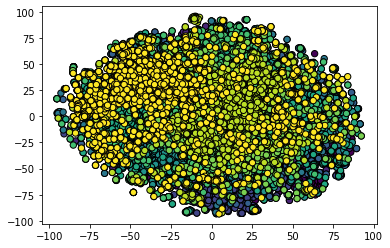

In [20]:
cls.tsne(tf_idf10, num_labels10)

### Классификация

In [30]:
title10_tf_idf = TfidfVectorizer(max_features=2000, stop_words='english').fit_transform(title10).toarray()
# keywords10_tf_idf = TfidfVectorizer(max_features=None, stop_words='english').fit_transform(keywords10).toarray()
# annotation10_tf_idf = TfidfVectorizer(max_features=None, stop_words='english').fit_transform(annotation10).toarray()
united_signs10_tf_idf = TfidfVectorizer(max_features=None, stop_words='english').fit_transform(united_signs10).toarray()

In [27]:
print(title10_tf_idf.shape)
# print(keywords10_tf_idf.shape)
# print(annotation10_tf_idf.shape)
print(united_signs10_tf_idf.shape)

(19027, 13880)
(19027, 416)
(19027, 41768)
(19027, 42969)


In [31]:
x_train, x_test, y_train, y_test = train_test_split(united_signs10_tf_idf, labels10, train_size=0.3, random_state=0)

### Первый этап

In [17]:
parameters = {
    'n_neighbors': (10, 50, 100, 500),
    'metric': ('euclidean', 'manhattan', 'minkowski', 'cosine', 'chebyshev', 'mahalanobis', 'seuclidean'),
    'p': (1, 2),
    'weights': ('uniform', 'distance'),
    'algorithm': ('brute', 'kd_tree', 'ball_tree'),
}

In [18]:
param = {}
for key in list(parameters.keys()):
    print(key)
    param.update({key: parameters[key]})
    clf = KNeighborsClassifier()
    prediction, classificationReport, best_params = cls.classifier(x_train, x_test, y_train, y_test, clf, param)
    param = best_params
    for key in list(param.keys()):
        param.update({key: (param[key],)})

n_neighbors
metric


c:\Users\Igorexy\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [0.63192141 0.29449654 0.63192141 0.63192141 0.1774709         nan
        nan]
  warnings.warn(


p
weights
algorithm


In [19]:
print(classificationReport)
best_params

                       precision    recall  f1-score   support

      computer vision       0.42      0.78      0.55      1245
      control systems       0.68      0.50      0.58      1031
       cyber security       0.61      0.94      0.74      2015
             database       0.88      0.18      0.30      1330
               expert       0.81      0.25      0.38      1332
                fuzzy       0.91      0.75      0.82      1232
information retrieval       0.74      0.67      0.70      1398
          neural nets       0.69      0.57      0.63      1313
              robotic       0.71      0.68      0.69      1068
          text mining       0.56      0.86      0.68      1355

             accuracy                           0.63     13319
            macro avg       0.70      0.62      0.61     13319
         weighted avg       0.70      0.63      0.61     13319



{'algorithm': ('brute',),
 'metric': ('euclidean',),
 'n_neighbors': (500,),
 'p': (1,),
 'weights': ('distance',)}

### Этап донастройки

In [36]:
_pcaRes

(array([[-0.08101594,  0.00854087],
        [-0.14803393, -0.00711777],
        [-0.14698643, -0.04262413],
        ...,
        [ 0.04459024,  0.00528488],
        [ 0.05026557,  0.08090325],
        [ 0.02872109,  0.0874203 ]]),
 array([[-0.08101486,  0.00858655, -0.01960479],
        [-0.14809044, -0.00743032, -0.0841615 ],
        [-0.14697519, -0.04254971, -0.09987687],
        ...,
        [ 0.04460422,  0.00525135, -0.01808516],
        [ 0.05030086,  0.08108104, -0.04005961],
        [ 0.02874495,  0.08751237, -0.02459712]]))

In [37]:
x_train, x_test, y_train, y_test = train_test_split(_pcaRes[1], labels10, train_size=0.3, random_state=0)

In [45]:
param = {
    'n_estimators': (100, 500, 1000),
    'max_depth': (10, 100, 200, None),
    'criterion': ('gini', 'log_loss', 'entropy'),
    'max_features': (0.3, 0.5, "sqrt", "log2", None),
    'max_leaf_nodes': (100, 1000, 25000, None),
    'min_samples_split': (2, 5, 10),
    'min_samples_leaf':  (1, 2, 5, 10),
    'oob_score': (True, False),
    'bootstrap': (True, False),
}

clf = RandomForestClassifier(random_state=0)

prediction, classificationReport, best_params = cls.classifier(x_train, x_test, y_train, y_test, clf, param)
print(classificationReport)
best_params

                       precision    recall  f1-score   support

      computer vision       0.35      0.41      0.38      1245
      control systems       0.44      0.37      0.40      1031
       cyber security       0.72      0.85      0.78      2015
             database       0.26      0.25      0.25      1330
               expert       0.18      0.11      0.13      1332
                fuzzy       0.51      0.47      0.49      1232
information retrieval       0.61      0.56      0.58      1398
          neural nets       0.42      0.45      0.44      1313
              robotic       0.48      0.54      0.51      1068
          text mining       0.55      0.63      0.59      1355

             accuracy                           0.49     13319
            macro avg       0.45      0.46      0.46     13319
         weighted avg       0.47      0.49      0.47     13319



{'n_estimators': 100}

In [33]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, prediction)

array([[ 798,   18,   98,   23,   27,   18,   20,   60,   62,  121],
       [  67,  502,  180,   24,   29,   18,   23,   47,  104,   37],
       [  52,   20, 1817,   25,   12,   21,   18,   19,   10,   21],
       [ 156,   26,  218,  399,   51,   54,  138,   94,   39,  155],
       [ 153,   69,  163,   54,  361,   67,   86,   91,   79,  209],
       [  32,   36,  122,   22,   17,  853,   47,   30,   24,   49],
       [  50,   11,  127,   45,   13,   36,  963,   15,   20,  118],
       [ 184,   51,  134,   49,   50,   47,   35,  632,   32,   99],
       [ 108,   97,   57,    7,   31,   15,    3,   23,  709,   18],
       [  76,    5,   80,   25,   31,   32,   77,   15,    4, 1010]],
      dtype=int64)

### Save

In [24]:
# autoTable(classificationReport, path='output/title10 RF.docx')

### Сравнительный график

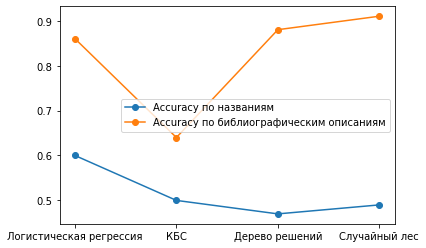

In [29]:
table_bin = pd.read_excel('Таблица метрик многоклассовой классификации.xlsx', index_col=0)
list(table_bin.index)
plt.figure()
plt.plot(list(table_bin.index), list(table_bin['Accuracy name']), marker='o', label='Accuracy по названиям')
plt.plot(list(table_bin.index), list(table_bin['Accuracy bibliographic description']), marker='o', label='Accuracy по библиографическим описаниям')
plt.legend()